In [5]:
import pandas as pd
import sys
from pathlib import Path
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sys.path.append(str(Path.cwd().parent.parent / "src")) # Necessário contar quantos niveis subir nas pastas, incluir 1 .parent para cada nivel.

# My custom functions and classes
from utils.paths import resolve_env_path, PROJECT_ROOT
from classes.time_series_dataset import TimeSeriesDataset
from classes.plotter import Plotter
from utils.calculations import plot_stl_decomposition
from utils.calculations import process_df

In [6]:
ARRIVALS_PATH = resolve_env_path("ARRIVALS_PATH")
arrivals_dataset = TimeSeriesDataset(ARRIVALS_PATH)

In [7]:
# Process data for Rio de Janeiro with continent information
df = arrivals_dataset.get_data_without_missing_values()


df_rj = process_df(
    df=df, 
    state="rio_de_janeiro", 
    agg_cols=["date", "continent"], 
    value_cols="arrivals", 
    agg_func="sum"
)

In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
from itertools import product
warnings.filterwarnings('ignore')

print("="*80)
print("XGBOOST GRIDSEARCH - MODELO INDIVIDUAL POR CONTINENTE")
print("="*80 + "\n")

def create_features_for_continent(df, target_col='arrivals'):
    """
    Cria features para XGBoost
    
    Features incluídas:
    - Temporais: month (sin/cos), year, quarter (sin/cos)
    - Lags: 1, 2, 3, 6, 12
    - COVID dummy
    - STL features (janela de 24 meses)
    """
    
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').reset_index(drop=True)

    # ✅ TRACKER DE LINHAS
    initial_rows = len(df)
    initial_date_range = (df['date'].min(), df['date'].max())
    
    print(f"\n📊 FEATURE ENGINEERING - TRACKING")
    print(f"{'='*60}")
    print(f"Dados iniciais:")
    print(f"  Linhas: {initial_rows}")
    print(f"  Período: {initial_date_range[0].strftime('%Y-%m')} a {initial_date_range[1].strftime('%Y-%m')}")
    print(f"  Frequência esperada: Mensal")
    
    # ========================================
    # 1. TIME FEATURES
    # ========================================
    df['year'] = df['date'].dt.year
    month = df['date'].dt.month
    quarter = df['date'].dt.quarter
    
    # Features cíclicas para mês (capturar sazonalidade)
    df['month_sin'] = np.sin(2 * np.pi * month / 12)
    df['month_cos'] = np.cos(2 * np.pi * month / 12)
    
    # Features cíclicas para quarter (capturar sazonalidade trimestral)
    df['quarter_sin'] = np.sin(2 * np.pi * quarter / 4)
    df['quarter_cos'] = np.cos(2 * np.pi * quarter / 4)
    
    # ========================================
    # 2. LAG FEATURES
    # ========================================
    lags = [1, 2, 3, 6, 12]
    for lag in lags:
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    
    rows_with_lag_nans = df[df['lag_12'].isna()].shape[0]
    print(f"\nApós criar lags [1,2,3,6,12]:")
    print(f"  Linhas com NaN em lag_12: {rows_with_lag_nans} (primeiras {rows_with_lag_nans} linhas)")
    
    # ========================================
    # 3. COVID DUMMY
    # ========================================
    covid_start = pd.Timestamp('2020-03-01')
    covid_end = pd.Timestamp('2023-05-01')
    
    df['covid_dummy'] = ((df['date'] >= covid_start) & 
                         (df['date'] < covid_end)).astype(int)

    # ========================================
    # 4. STL FEATURES (JANELA DESLIZANTE DE 24 MESES)
    # ========================================

    
    from statsmodels.tsa.seasonal import STL
    from scipy.stats import linregress
    from statsmodels.tsa.stattools import acf
    
    print("\n  Calculando features STL com janela deslizante de 24 meses...")
    
    # Inicializar colunas
    stl_features = {
        'seasonal_strength': [],
        'trend_strength': [],
        'seasonal_peak_year': [],
        'seasonal_trough_year': [],
        'spikiness': [],
        'linearity': [],
        'curvature': [],
        'stl_e_acf1': [],
        'stl_e_acf10': []
    }
    
    window_size = 24  # 24 meses
    stl_errors = 0  # ← FIX: Inicializar contador de erros
    
    for i in range(len(df)):
        if i < window_size :
            # Primeiros 24 meses: usar valores NaN
            for key in stl_features.keys():
                stl_features[key].append(np.nan)
        else:
            # Janela deslizante: últimos 24 meses
            window_data = df[target_col].iloc[i - window_size : i].values
            
            try:
                # STL Decomposition
                ts = pd.Series(window_data, 
                              index=pd.date_range(start='2000-01-01', periods=window_size, freq='MS'))
                
                stl = STL(ts, seasonal=13, trend=None, robust=True)
                result = stl.fit()
                
                trend = result.trend.values
                seasonal = result.seasonal.values
                residual = result.resid.values
                
                # 1. SEASONAL STRENGTH
                var_resid = np.var(residual)
                var_seasonal_resid = np.var(seasonal + residual)
                seasonal_strength = max(0, 1 - var_resid / var_seasonal_resid) if var_seasonal_resid > 0 else 0
                
                # 2. TREND STRENGTH
                var_trend_resid = np.var(trend + residual)
                trend_strength = max(0, 1 - var_resid / var_trend_resid) if var_trend_resid > 0 else 0
                
                # 3. SEASONAL PEAK YEAR
                seasonal_peak = np.argmax(seasonal) + 1
                
                # 4. SEASONAL TROUGH YEAR
                seasonal_trough = np.argmin(seasonal) + 1
                
                # 5. SPIKINESS
                variances = []
                for j in range(len(residual)):
                    loo_resid = np.delete(residual, j)
                    variances.append(np.var(loo_resid))
                spikiness = np.var(variances) if len(variances) > 0 else 0
                
                # 6. LINEARITY
                x_trend = np.arange(len(trend))
                slope, intercept, r_value, p_value, std_err = linregress(x_trend, trend)
                linearity = r_value ** 2
                
                # 7. CURVATURE
                A = np.vstack([np.ones(len(trend)), x_trend, x_trend**2]).T
                coeffs, residuals_reg, rank, s = np.linalg.lstsq(A, trend, rcond=None)
                curvature = abs(coeffs[2])
                
                # 8. STL_E_ACF1
                if len(residual) > 1:
                    acf1 = np.corrcoef(residual[:-1], residual[1:])[0, 1]
                else:
                    acf1 = 0
                
                # 9. STL_E_ACF10
                acf_values = acf(residual, nlags=10, fft=False)
                acf10 = np.sum(acf_values[1:11] ** 2)
                
                # Armazenar features
                stl_features['seasonal_strength'].append(seasonal_strength)
                stl_features['trend_strength'].append(trend_strength)
                stl_features['seasonal_peak_year'].append(seasonal_peak)
                stl_features['seasonal_trough_year'].append(seasonal_trough)
                stl_features['spikiness'].append(spikiness)
                stl_features['linearity'].append(linearity)
                stl_features['curvature'].append(curvature)
                stl_features['stl_e_acf1'].append(acf1)
                stl_features['stl_e_acf10'].append(acf10)
            
            except Exception as e:
                # Em caso de erro, adicionar NaNs
                stl_errors += 1
                for key in stl_features.keys():
                    stl_features[key].append(np.nan)
    
    # ✅ FIX PRINCIPAL: ADICIONAR AS FEATURES STL AO DATAFRAME
    for feature_name, feature_values in stl_features.items():
        df[feature_name] = feature_values
    
    rows_with_stl_nans = df['seasonal_strength'].isna().sum()
    print(f"  Linhas com NaN em STL features: {rows_with_stl_nans} (primeiras {window_size} + erros)")
    print(f"  Erros ao calcular STL: {stl_errors}")

    # ========================================
    # 5. ANÁLISE PRÉ-DROPNA
    # ========================================
    print(f"\n📉 ANÁLISE PRÉ-DROPNA:")
    total_nans = df.isna().sum().sum()
    rows_with_any_nan = df.isna().any(axis=1).sum()
    print(f"  Total de valores NaN: {total_nans}")
    print(f"  Linhas com pelo menos 1 NaN: {rows_with_any_nan}")
    
    # Identificar quais colunas têm mais NaNs
    nan_counts = df.isna().sum()
    nan_counts = nan_counts[nan_counts > 0].sort_values(ascending=False)
    if len(nan_counts) > 0:
        print(f"\n  Colunas com NaN (top 5):")
        for col, count in nan_counts.head(5).items():
            print(f"    {col}: {count} NaNs")
    
    # ========================================
    # 6. DROPNA E DETECÇÃO DE QUEBRAS TEMPORAIS
    # ========================================
    df_before_dropna = df.copy()
    df = df.dropna()
    
    rows_after_dropna = len(df)
    rows_removed = initial_rows - rows_after_dropna
    final_date_range = (df['date'].min(), df['date'].max()) if len(df) > 0 else (None, None)
    
    print(f"\n📊 RESULTADO APÓS DROPNA:")
    print(f"  Linhas removidas: {rows_removed} ({rows_removed/initial_rows*100:.1f}%)")
    print(f"  Linhas finais: {rows_after_dropna}")
    
    if len(df) > 0:
        print(f"  Período final: {final_date_range[0].strftime('%Y-%m')} a {final_date_range[1].strftime('%Y-%m')}")
        
        # ✅ DETECÇÃO DE QUEBRAS TEMPORAIS
        df_sorted = df.sort_values('date').reset_index(drop=True)
        date_diffs = df_sorted['date'].diff()
        
        # Espera-se ~30 dias entre meses consecutivos
        expected_diff = pd.Timedelta(days=30)
        tolerance = pd.Timedelta(days=5)  # ±5 dias de tolerância
        
        breaks = date_diffs[(date_diffs > expected_diff + tolerance) | (date_diffs < expected_diff - tolerance)]
        
        if len(breaks) > 0:
            print(f"\n  ⚠️ QUEBRAS TEMPORAIS DETECTADAS: {len(breaks)}")
            print(f"  Locais das quebras (primeiras 5):")
            for idx, diff in breaks.head(5).items():
                if idx > 0:  # idx=0 é sempre NaT
                    prev_date = df_sorted.loc[idx-1, 'date']
                    curr_date = df_sorted.loc[idx, 'date']
                    print(f"    Entre {prev_date.strftime('%Y-%m')} e {curr_date.strftime('%Y-%m')} ({diff.days} dias)")
        else:
            print(f"\n  ✅ SEM QUEBRAS TEMPORAIS - Série contínua mensal")
    else:
        print(f"  ⚠️ ATENÇÃO: DataFrame vazio após dropna!")
    
    # ========================================
    # 7. ESTATÍSTICAS FINAIS
    # ========================================
    feature_stats = {
        'initial_rows': initial_rows,
        'final_rows': rows_after_dropna,
        'rows_removed': rows_removed,
        'removal_pct': rows_removed / initial_rows * 100 if initial_rows > 0 else 0,
        'initial_date_range': initial_date_range,
        'final_date_range': final_date_range,
        'has_temporal_breaks': len(breaks) > 0 if len(df) > 0 else None,
        'num_temporal_breaks': len(breaks) if len(df) > 0 else None,
        'stl_errors': stl_errors,
        'lag_nans': rows_with_lag_nans,
        'stl_nans': rows_with_stl_nans
    }
    
    print(f"\n{'='*60}")
    print(f"✓ Feature engineering concluído")
    print(f"{'='*60}\n")
    
    return df, feature_stats


# ========================================
# GRID DE HIPERPARÂMETROS
# ========================================
param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.03, 0.05],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.6, 0.7, 0.8],
}

print("Grid de hiperparâmetros:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

total_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"\nTotal de combinações: {total_combinations}")
print(f"Critério de seleção: MENOR RMSE DE TESTE")
print(f"  -> Objetivo: Maximizar performance em dados não vistos")

# ========================================
# TRAINING PIPELINE
# ========================================
train_end = pd.Timestamp('2023-12-31')
test_start = pd.Timestamp('2024-01-01')

print(f"\nTraining period: até {train_end.strftime('%Y-%m-%d')}")
print(f"Test period: de {test_start.strftime('%Y-%m-%d')} em diante")
print("\n" + "="*80 + "\n")

# Get unique continents
continents = ['TOTAL'] + sorted(df_rj['continent'].unique())
print(f"Continentes a processar: {len(continents)}")
for i, cont in enumerate(continents, 1):
    print(f"  {i}. {cont.title()}")

print("\n" + "="*80 + "\n")

# Storage for models and results
xgb_models = {}
xgb_results = []

# ========================================
# GRIDSEARCH POR CONTINENTEcontinent_display
# ========================================
for continent in continents:
    print(f"\n{'='*80}")
    print(f"GRIDSEARCH: {continent.upper()}")
    print(f"{'='*80}\n")
    
    # Filter data for this continent
    if continent == 'TOTAL':
        # Agregar todas as chegadas por data
        continent_data = (
            df_rj.groupby('date', as_index=False)
            .agg({'arrivals': 'sum'})
            .sort_values('date')
    )
    else:
        # Filtrar por continente específico
        continent_data = df_rj[df_rj['continent'] == continent].copy()
    print(f"Observações totais: {len(continent_data)}")
    print(f"Período: {continent_data['date'].min()} a {continent_data['date'].max()}")
    
    # Create features
    print("\nCriando features...")
    df_features, _ = create_features_for_continent(continent_data)
    
    # Split train/test
    train_data = df_features[df_features['date'] <= train_end]
    test_data = df_features[df_features['date'] >= test_start]
    
    print(f"\n--- Train/Test Split ---")
    print(f"  Train: {len(train_data)} observações ({train_data['date'].min()} a {train_data['date'].max()})")
    print(f"  Test:  {len(test_data)} observações ({test_data['date'].min()} a {test_data['date'].max()})")
    
    if len(test_data) == 0:
        print("\n⚠️ AVISO: Sem dados de teste - pulando continente")
        continue
    
    # Define features and target
    feature_cols = [col for col in df_features.columns 
                    if col not in ['date', 'continent', 'arrivals']]
    
    X_train = train_data[feature_cols]
    y_train = train_data['arrivals']
    X_test = test_data[feature_cols]
    y_test = test_data['arrivals']
    
    print(f"\n--- Features ---")
    print(f"  Total de features: {len(feature_cols)}")
    print(f"  Shape X_train: {X_train.shape}")
    print(f"  Shape X_test: {X_test.shape}")
    
    # ========================================
    # GRID SEARCH MANUAL (CRITÉRIO: MENOR RMSE TEST)
    # ========================================
    print(f"\nIniciando GridSearch ({total_combinations} combinações)...")
    print(f"Critério: Minimizar RMSE de Teste\n")
    start_time = time.time()
    
    best_rmse_test = float('inf')
    best_params = None
    best_model = None
    best_rmse_train = None
    best_gap = None
    
    all_results = []
    
    # Gerar todas as combinações
    param_combinations = list(product(
        param_grid['n_estimators'],
        param_grid['learning_rate'],
        param_grid['max_depth'],
        param_grid['min_child_weight'],
        param_grid['subsample'],
        param_grid['colsample_bytree']
    ))
    
    # ✅ DEFINIR NOME DO CONTINENTE (ANTES DO LOOP)
    continent_display = "TOTAL (Agregado)" if continent == 'TOTAL' else continent.title()

    # Loop por todas as combinações
    for i, (n_est, lr, md, mcw, ss, csb) in enumerate(param_combinations, 1):
        # Criar modelo
        model = xgb.XGBRegressor(
            n_estimators=n_est,
            learning_rate=lr,
            max_depth=md,
            min_child_weight=mcw,
            subsample=ss,
            colsample_bytree=csb,
            random_state=42,
            verbosity=0
        )
        
        # Treinar
        model.fit(X_train, y_train)
        
        # Predizer
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

         # MAE
        mae_train = mean_absolute_error(y_train, y_pred_train)
        mae_test = mean_absolute_error(y_test, y_pred_test)
        
        # MAPE (com proteção para divisão por zero)
        mask_train = y_train > 0
        mask_test = y_test > 0
        
        mape_train = np.mean(np.abs((y_train[mask_train] - y_pred_train[mask_train]) / y_train[mask_train])) * 100 if mask_train.sum() > 0 else np.nan
        mape_test = np.mean(np.abs((y_test[mask_test] - y_pred_test[mask_test]) / y_test[mask_test])) * 100 if mask_test.sum() > 0 else np.nan
        
        # Calcular GAP
        gap = abs(rmse_train - rmse_test)

        # ✅ LJUNG-BOX TEST (Autocorrelação dos resíduos de treino)
        residuals_train = y_train.values - y_pred_train

        try:
            from statsmodels.stats.diagnostic import acorr_ljungbox
            lb_test = acorr_ljungbox(residuals_train, lags=24, return_df=True)
            lb_pvalue = lb_test['lb_pvalue'].iloc[-1]  # p-value do último lag (16)
            lb_statistic = lb_test['lb_stat'].iloc[-1]
            lb_result = "Pass" if lb_pvalue > 0.05 else "Fail"
        except Exception as e:
            lb_pvalue = np.nan
            lb_statistic = np.nan
            lb_result = "Error"
        
        # Armazenar
        params = {
            'n_estimators': n_est,
            'learning_rate': lr,
            'max_depth': md,
            'min_child_weight': mcw,
            'subsample': ss,
            'colsample_bytree': csb
        }
        
        all_results.append({
            # ✅ IDENTIFICAÇÃO
            'continent': continent_display,
            'iteration': i,


            # Hiperparâmetros
            'params': params,  # Dicionário completo (compatibilidade)
            'n_estimators': n_est,
            'learning_rate': lr,
            'max_depth': md,
            'min_child_weight': mcw,
            'subsample': ss,
            'colsample_bytree': csb,
            
            # Métricas de Performance
            'rmse_train': rmse_train,
            'rmse_test': rmse_test,
            'mae_train': mae_train,
            'mae_test': mae_test,
            'mape_train': mape_train,
            'mape_test': mape_test,
            
            # Métricas Derivadas
            'gap': gap,
            'ratio': rmse_test / rmse_train if rmse_train > 0 else float('inf'),
            
            # Teste Estatístico (Ljung-Box)
            'lb_pvalue': lb_pvalue,
            'lb_statistic': lb_statistic,
            'lb_result': lb_result
        })
        
        # Atualizar melhor modelo (MENOR RMSE TEST)
        if rmse_test < best_rmse_test:
            best_rmse_test = rmse_test
            best_rmse_train = rmse_train
            best_gap = gap
            best_params = params.copy()
            best_model = model
        
        # Progress
        if i % 30 == 0 or i == len(param_combinations):
            print(f"  {i}/{len(param_combinations)} ({i/len(param_combinations)*100:.1f}%) | Melhor Test RMSE: {best_rmse_test:.2f} (Train={best_rmse_train:.2f}, GAP={best_gap:.2f})")
    
    elapsed_time = time.time() - start_time
    
    # ========================================
    # RESULTADOS
    # ========================================
    print(f"\n{'='*60}")
    print(f"RESULTADOS - {continent.upper()}")
    print(f"{'='*60}")
    print(f"Tempo: {elapsed_time:.2f}s ({elapsed_time/60:.2f} min)")
    print(f"\nMelhor modelo (menor RMSE test):")
    print(f"  RMSE Train: {best_rmse_train:.2f}")
    print(f"  RMSE Test:  {best_rmse_test:.2f}")
    print(f"  GAP:        {best_gap:.2f}")
    print(f"  Ratio:      {best_rmse_test / best_rmse_train:.2f}")
    
    print(f"\nMelhores parâmetros:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")
    
    # Métricas completas
    y_pred_train_final = best_model.predict(X_train)
    y_pred_test_final = best_model.predict(X_test)
    
    mae_train = mean_absolute_error(y_train, y_pred_train_final)
    mae_test = mean_absolute_error(y_test, y_pred_test_final)
    
    mask_train = y_train > 0
    mask_test = y_test > 0
    
    mape_train = np.mean(np.abs((y_train[mask_train] - y_pred_train_final[mask_train]) / y_train[mask_train])) * 100 if mask_train.sum() > 0 else np.nan
    mape_test = np.mean(np.abs((y_test[mask_test] - y_pred_test_final[mask_test]) / y_test[mask_test])) * 100 if mask_test.sum() > 0 else np.nan
    
    print(f"\n--- Performance Metrics ---")
    print(f"TRAIN: RMSE={best_rmse_train:.2f} | MAE={mae_train:.2f} | MAPE={mape_train:.2f}%")
    print(f"TEST:  RMSE={best_rmse_test:.2f} | MAE={mae_test:.2f} | MAPE={mape_test:.2f}%")
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Top 5 modelos por RMSE Test
    all_results_df = pd.DataFrame(all_results)
    all_results_df = all_results_df.sort_values('rmse_test')
    
    print(f"\n--- Top 5 Modelos (Menor RMSE Test) ---")
    for idx, (_, row) in enumerate(all_results_df.head(5).iterrows(), 1):
        print(f"{idx}. Test RMSE={row['rmse_test']:.2f} | Train={row['rmse_train']:.2f} | GAP={row['gap']:.2f} | Ratio={row['ratio']:.2f}")
    
    # Armazenar
    xgb_models[continent] = {
        'model': best_model,
        'feature_cols': feature_cols,
        'train_data': train_data,
        'test_data': test_data,
        'y_pred_train': y_pred_train_final,
        'y_pred_test': y_pred_test_final,
        'feature_importance': feature_importance,
        'all_results': all_results_df
    }

    continent_display = "TOTAL (Agregado)" if continent == 'TOTAL' else continent.title()
    
    xgb_results.append({
        'Continent': continent_display,
        'Train_RMSE': best_rmse_train,
        'Test_RMSE': best_rmse_test,
        'GAP': best_gap,
        'Ratio': best_rmse_test / best_rmse_train,
        'Train_MAE': mae_train,
        'Test_MAE': mae_test,
        'Train_MAPE': mape_train,
        'Test_MAPE': mape_test,
        'n_estimators': best_params['n_estimators'],
        'learning_rate': best_params['learning_rate'],
        'max_depth': best_params['max_depth'],
        'min_child_weight': best_params['min_child_weight'],
        'subsample': best_params['subsample'],
        'colsample_bytree': best_params['colsample_bytree'],
        'Time_min': elapsed_time / 60
    })
    
    print(f"\n✓ GridSearch para {continent} concluído!")


# ========================================
# RESUMO GERAL
# ========================================
print("\n" + "="*80)
print("RESUMO GRIDSEARCH - TODOS OS CONTINENTES")
print("="*80 + "\n")

results_df = pd.DataFrame(xgb_results)
print(results_df[['Continent', 'Train_RMSE', 'Test_RMSE', 'GAP', 'Ratio', 'Test_MAE', 'Test_MAPE']].to_string(index=False))

print("\n" + "="*80)
print("RANKING POR TEST RMSE (Critério Principal)")
print("="*80 + "\n")

ranking_test = results_df.sort_values('Test_RMSE')[['Continent', 'Test_RMSE', 'Test_MAE', 'Test_MAPE', 'GAP', 'Ratio']]
print(ranking_test.to_string(index=False))

print("\n" + "="*80)
print("RANKING POR MENOR GAP (Train-Test mais próximos)")
print("="*80 + "\n")

ranking_gap = results_df.sort_values('GAP')[['Continent', 'Train_RMSE', 'Test_RMSE', 'GAP', 'Ratio']]
print(ranking_gap.to_string(index=False))

print("\n" + "="*80)
print("ESTATÍSTICAS DOS HIPERPARÂMETROS SELECIONADOS")
print("="*80 + "\n")

print(f"n_estimators - Média: {results_df['n_estimators'].mean():.0f} | Moda: {results_df['n_estimators'].mode()[0]}")
print(f"learning_rate - Média: {results_df['learning_rate'].mean():.3f} | Moda: {results_df['learning_rate'].mode()[0]}")
print(f"max_depth - Média: {results_df['max_depth'].mean():.1f} | Moda: {results_df['max_depth'].mode()[0]}")
print(f"min_child_weight - Média: {results_df['min_child_weight'].mean():.1f} | Moda: {results_df['min_child_weight'].mode()[0]}")
print(f"subsample - Média: {results_df['subsample'].mean():.2f} | Moda: {results_df['subsample'].mode()[0]}")
print(f"colsample_bytree - Média: {results_df['colsample_bytree'].mean():.2f} | Moda: {results_df['colsample_bytree'].mode()[0]}")

print("\n" + "="*80)
print("✓ GRIDSEARCH CONCLUÍDO")
print("="*80)

XGBOOST GRIDSEARCH - MODELO INDIVIDUAL POR CONTINENTE

Grid de hiperparâmetros:
  n_estimators: [100, 150, 200]
  learning_rate: [0.01, 0.03, 0.05]
  max_depth: [3, 4, 5]
  min_child_weight: [1, 3, 5]
  subsample: [0.6, 0.7, 0.8]
  colsample_bytree: [0.6, 0.7, 0.8]

Total de combinações: 729
Critério de seleção: MENOR RMSE DE TESTE
  -> Objetivo: Maximizar performance em dados não vistos

Training period: até 2023-12-31
Test period: de 2024-01-01 em diante


Continentes a processar: 8
  1. Total
  2. Africa
  3. America_Central_E_Caribe
  4. America_Do_Norte
  5. America_Do_Sul
  6. Asia
  7. Europa
  8. Oceania



GRIDSEARCH: TOTAL

Observações totais: 300
Período: 2000-01-01 00:00:00 a 2024-12-01 00:00:00

Criando features...

📊 FEATURE ENGINEERING - TRACKING
Dados iniciais:
  Linhas: 300
  Período: 2000-01 a 2024-12
  Frequência esperada: Mensal

Após criar lags [1,2,3,6,12]:
  Linhas com NaN em lag_12: 12 (primeiras 12 linhas)

  Calculando features STL com janela deslizante de 24 

In [ ]:
all_results

[{'continent': 'Oceania',
  'iteration': 1,
  'params': {'n_estimators': 100,
   'learning_rate': 0.01,
   'max_depth': 3,
   'min_child_weight': 1,
   'subsample': 0.6,
   'colsample_bytree': 0.6},
  'n_estimators': 100,
  'learning_rate': 0.01,
  'max_depth': 3,
  'min_child_weight': 1,
  'subsample': 0.6,
  'colsample_bytree': 0.6,
  'rmse_train': np.float64(644.1968263970024),
  'rmse_test': np.float64(378.94800576291567),
  'mae_train': 356.91009868275034,
  'mae_test': 331.0178527832031,
  'mape_train': np.float64(618.8384001575832),
  'mape_test': np.float64(31.786472045055998),
  'gap': np.float64(265.2488206340867),
  'ratio': np.float64(0.5882487932801139),
  'lb_pvalue': np.float64(3.948783971508468e-15),
  'lb_statistic': np.float64(122.18787016013898),
  'lb_result': 'Fail'},
 {'continent': 'Oceania',
  'iteration': 2,
  'params': {'n_estimators': 100,
   'learning_rate': 0.01,
   'max_depth': 3,
   'min_child_weight': 1,
   'subsample': 0.6,
   'colsample_bytree': 0.7},
 

In [9]:
# ✅ CONSOLIDAR PREVISÕES DE TODOS OS CONTINENTES
all_forecasts = []

for continent in continents:
    if continent not in xgb_models:
        continue
    
    model_data = xgb_models[continent]
    test_data = model_data['test_data']
    y_pred_test = model_data['y_pred_test']
    
    continent_display = "TOTAL (Agregado)" if continent == 'TOTAL' else continent.title()
    
    # ✅ FIX: Calcular pct_error com numpy, depois substituir inf/nan
    actual = test_data['arrivals'].values
    forecast = y_pred_test
    pct_error = ((actual - forecast) / actual) * 100
    pct_error = np.where(np.isinf(pct_error) | np.isnan(pct_error), np.nan, pct_error)
    
    forecast_df = pd.DataFrame({
        'date': test_data['date'].values,
        'continent': continent_display,
        'actual': actual,
        'forecast': forecast,
        'error': actual - forecast,
        'abs_error': np.abs(actual - forecast),
        'pct_error': pct_error
    })
    
    all_forecasts.append(forecast_df)

# Consolidar
forecasts_final = pd.concat(all_forecasts, ignore_index=True)

print("="*80)
print("PREVISÕES CONSOLIDADAS - XGBOOST")
print("="*80)
print(f"Total de previsões: {len(forecasts_final)}")
print(f"Continentes: {forecasts_final['continent'].nunique()}")
print(f"Período: {forecasts_final['date'].min().strftime('%Y-%m')} a {forecasts_final['date'].max().strftime('%Y-%m')}")

display(forecasts_final.head(20))

# Salvar
output_path = PROJECT_ROOT / "notebooks" / "modeling" / "xgboost_forecasts.csv"
forecasts_final.to_csv(output_path, index=False)
print(f"\n✓ Salvo em: {output_path}")

PREVISÕES CONSOLIDADAS - XGBOOST
Total de previsões: 96
Continentes: 8
Período: 2024-01 a 2024-12


,date,continent,actual,forecast,error,abs_error,pct_error
0,2024-01-01,TOTAL (Agregado),163598.0,141374.906250,22223.093750,22223.093750,13.583964
1,2024-02-01,TOTAL (Agregado),170305.0,136395.796875,33909.203125,33909.203125,19.910868
2,2024-03-01,TOTAL (Agregado),157683.0,127224.703125,30458.296875,30458.296875,19.316158
3,2024-04-01,TOTAL (Agregado),102172.0,87881.398438,14290.601562,14290.601562,13.986808
4,2024-05-01,TOTAL (Agregado),84116.0,84481.281250,-365.281250,365.281250,-0.434259
5,2024-06-01,TOTAL (Agregado),82402.0,81968.546875,433.453125,433.453125,0.526023
6,2024-07-01,TOTAL (Agregado),108089.0,90105.765625,17983.234375,17983.234375,16.637432
7,2024-08-01,TOTAL (Agregado),91504.0,106776.359375,-15272.359375,15272.359375,-16.690374
8,2024-09-01,TOTAL (Agregado),116003.0,95834.257812,20168.742188,20168.742188,17.386397
9,2024-10-01,TOTAL (Agregado),130985.0,124117.007812,6867.992188,6867.992188,5.243343



✓ Salvo em: C:\Users\f0oo\OneDrive - PETROBRAS\Documentos\international_arrivals_time_series_forecasting\notebooks\modeling\xgboost_forecasts.csv


VISUALIZAÇÕES - XGBOOST RESULTADOS


Gerando gráficos para: Total

--- Residual Diagnostics (Training Set) ---
Residual Mean: 145.5083
Residual Std: 9508.63

T-Test for Zero Mean:
  t-statistic: 0.2482
  p-value: 0.8042
  ✓ PASS: Mean não é significativamente diferente de zero (p > 0.05)
  ✓✓ EXCELENTE: |Mean| < 5% do Std (475.43)

Ljung-Box Test (lag 24):
  p-value: 0.0444
  ✗ FAIL: Significant autocorrelation detected (p < 0.05)

Jarque-Bera Test (Normality):
  Statistic: 3872.5948
  p-value: 0.0000
  ✗ FAIL: Residuals are not normally distributed (p < 0.05)

ARCH Test (Heteroskedasticity):
  p-value: 0.8339
  ✓ PASS: No heteroskedasticity (p > 0.05)

--- Overall Residual Diagnostics ---
⚠️ SOME TESTS FAILED - Review residual diagnostics


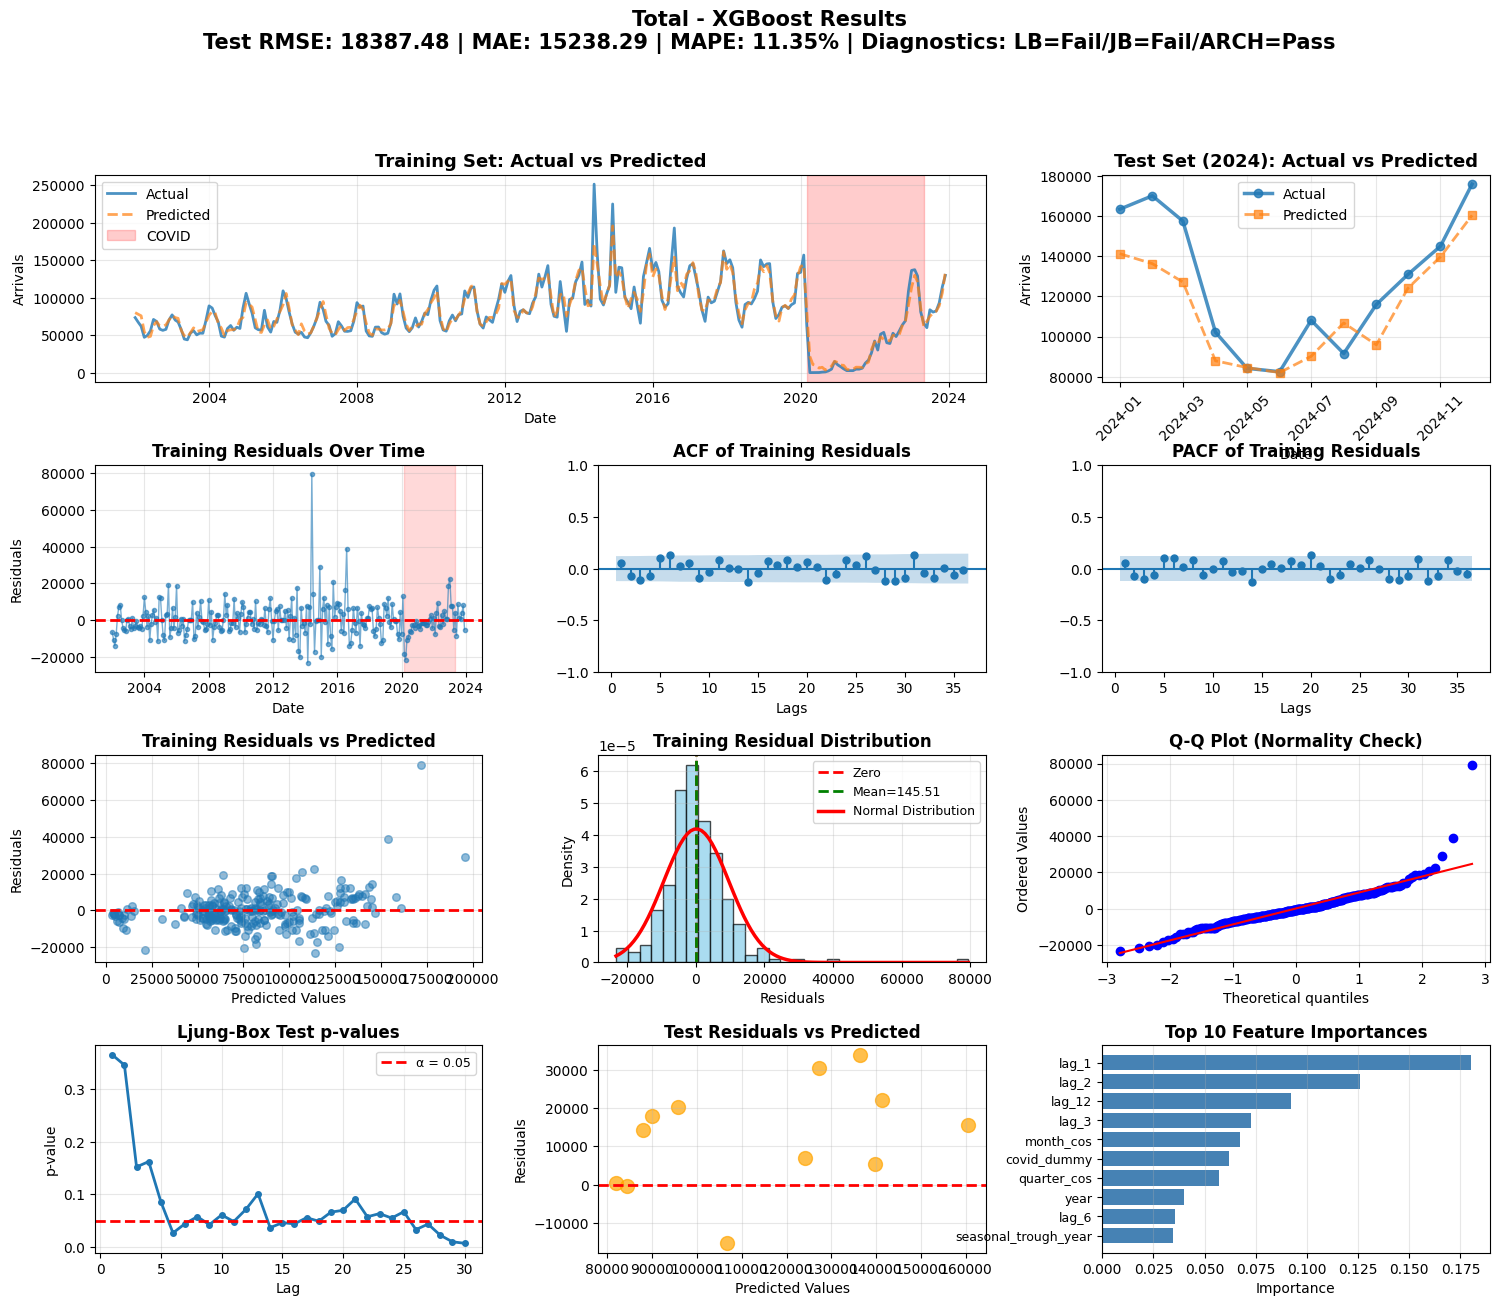


Gerando gráficos para: Africa

--- Residual Diagnostics (Training Set) ---
Residual Mean: 0.1171
Residual Std: 296.53

T-Test for Zero Mean:
  t-statistic: 0.0064
  p-value: 0.9949
  ✓ PASS: Mean não é significativamente diferente de zero (p > 0.05)
  ✓✓ EXCELENTE: |Mean| < 5% do Std (14.83)

Ljung-Box Test (lag 24):
  p-value: 0.0967
  ✓ PASS: No significant autocorrelation (p > 0.05)

Jarque-Bera Test (Normality):
  Statistic: 1554.8941
  p-value: 0.0000
  ✗ FAIL: Residuals are not normally distributed (p < 0.05)

ARCH Test (Heteroskedasticity):
  p-value: 0.7872
  ✓ PASS: No heteroskedasticity (p > 0.05)

--- Overall Residual Diagnostics ---
⚠️ SOME TESTS FAILED - Review residual diagnostics


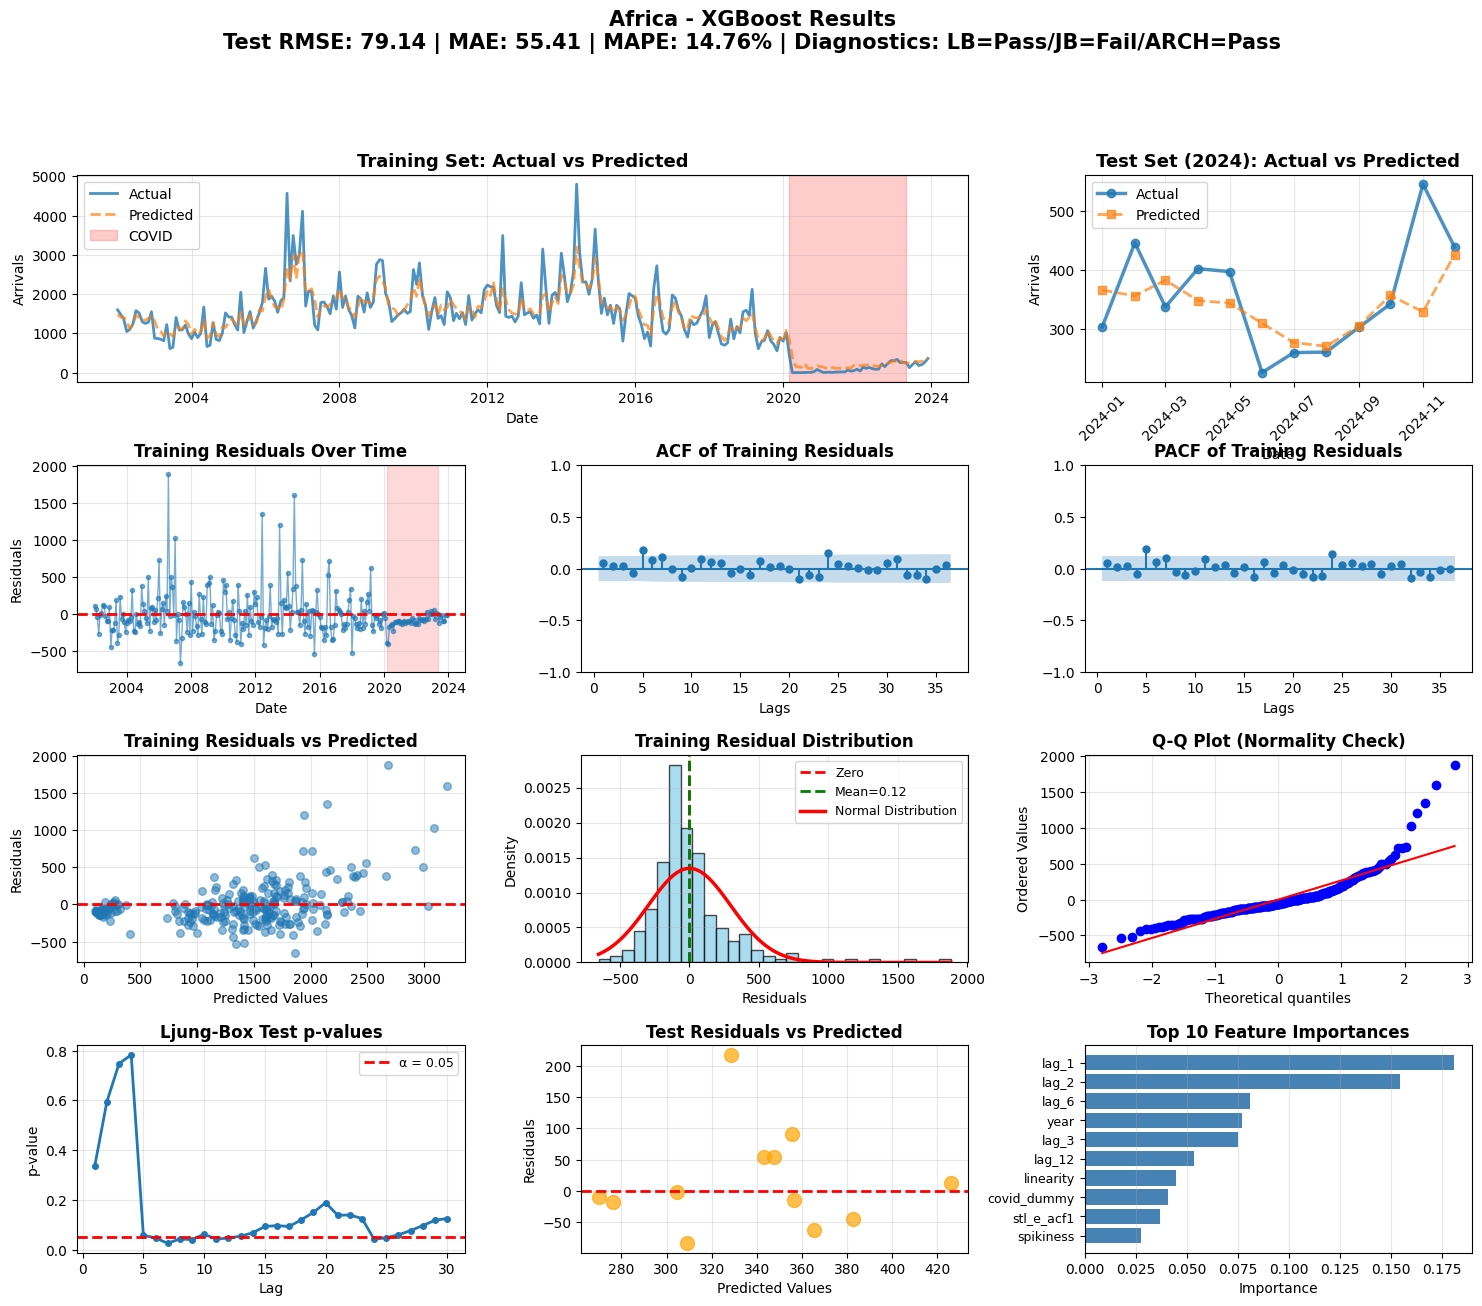


Gerando gráficos para: America_Central_E_Caribe

--- Residual Diagnostics (Training Set) ---
Residual Mean: 1.6787
Residual Std: 118.42

T-Test for Zero Mean:
  t-statistic: 0.2299
  p-value: 0.8184
  ✓ PASS: Mean não é significativamente diferente de zero (p > 0.05)
  ✓✓ EXCELENTE: |Mean| < 5% do Std (5.92)

Ljung-Box Test (lag 24):
  p-value: 0.0284
  ✗ FAIL: Significant autocorrelation detected (p < 0.05)

Jarque-Bera Test (Normality):
  Statistic: 753.4707
  p-value: 0.0000
  ✗ FAIL: Residuals are not normally distributed (p < 0.05)

ARCH Test (Heteroskedasticity):
  p-value: 0.9998
  ✓ PASS: No heteroskedasticity (p > 0.05)

--- Overall Residual Diagnostics ---
⚠️ SOME TESTS FAILED - Review residual diagnostics


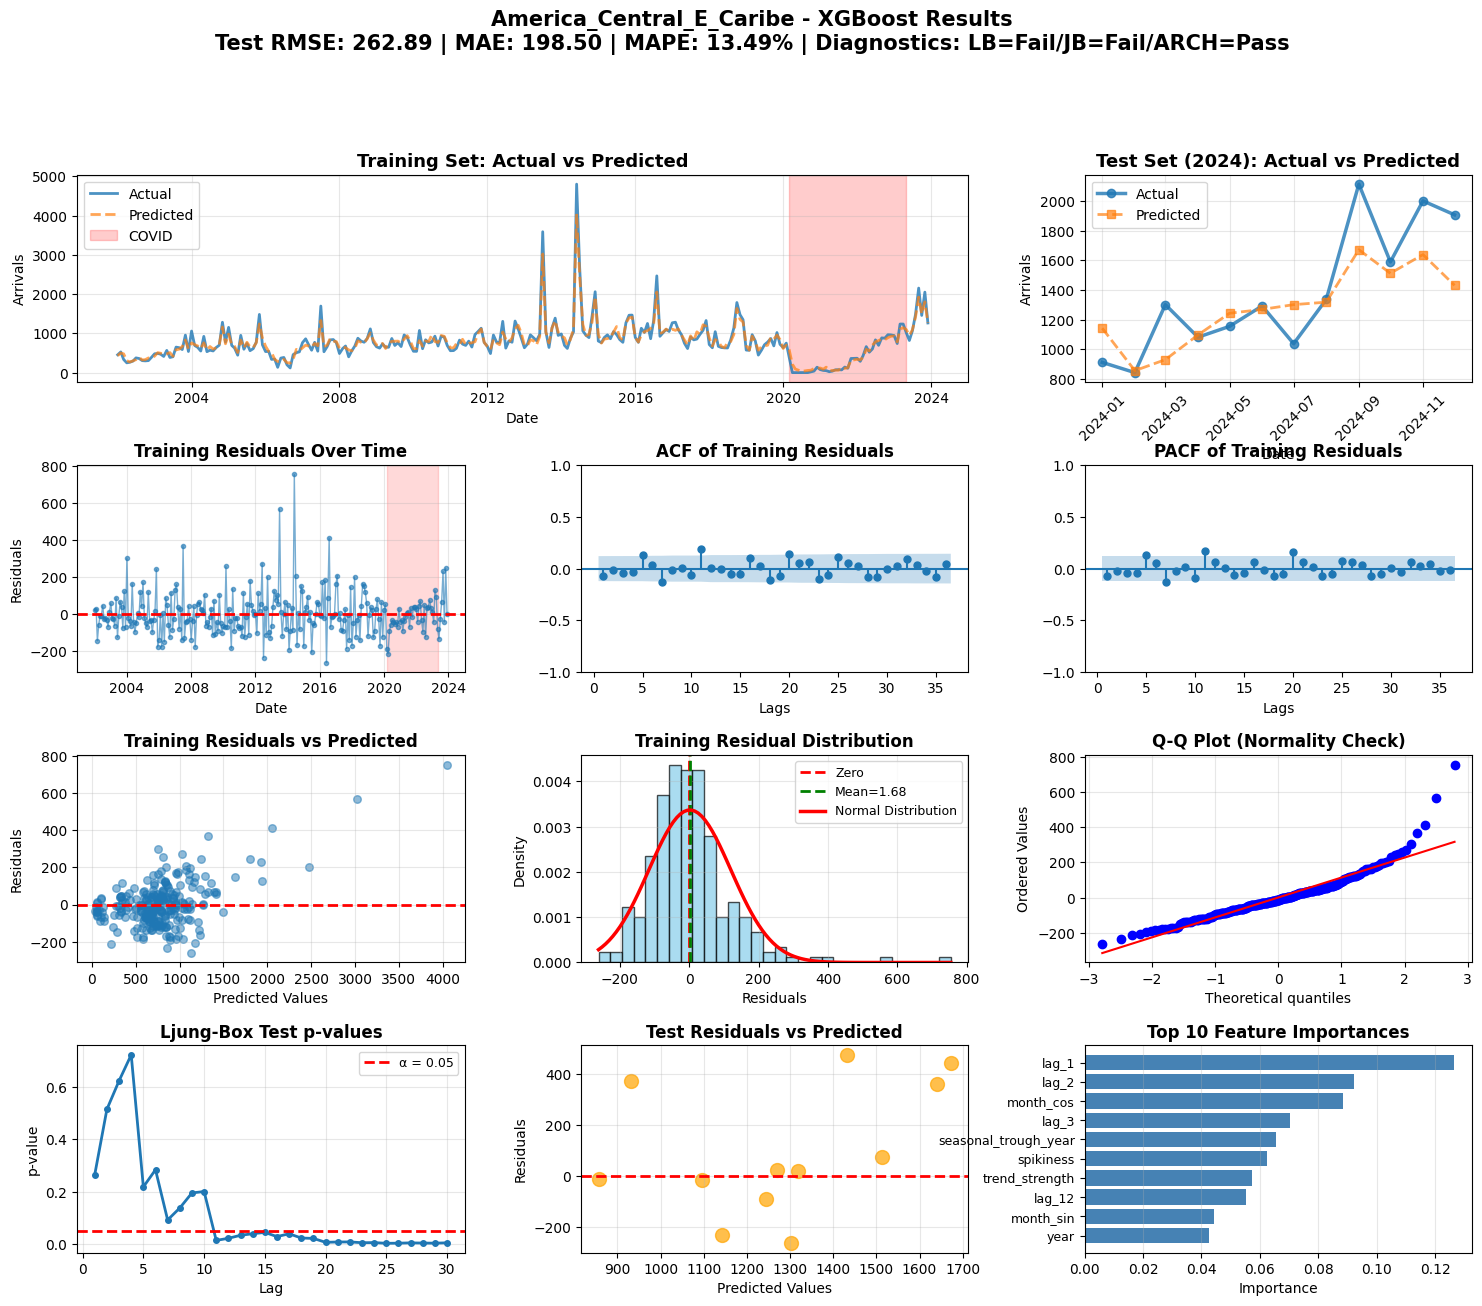


Gerando gráficos para: America_Do_Norte

--- Residual Diagnostics (Training Set) ---
Residual Mean: 8.2933
Residual Std: 906.60

T-Test for Zero Mean:
  t-statistic: 0.1484
  p-value: 0.8822
  ✓ PASS: Mean não é significativamente diferente de zero (p > 0.05)
  ✓✓ EXCELENTE: |Mean| < 5% do Std (45.33)

Ljung-Box Test (lag 24):
  p-value: 0.3390
  ✓ PASS: No significant autocorrelation (p > 0.05)

Jarque-Bera Test (Normality):
  Statistic: 57.4423
  p-value: 0.0000
  ✗ FAIL: Residuals are not normally distributed (p < 0.05)

ARCH Test (Heteroskedasticity):
  p-value: 0.9402
  ✓ PASS: No heteroskedasticity (p > 0.05)

--- Overall Residual Diagnostics ---
⚠️ SOME TESTS FAILED - Review residual diagnostics


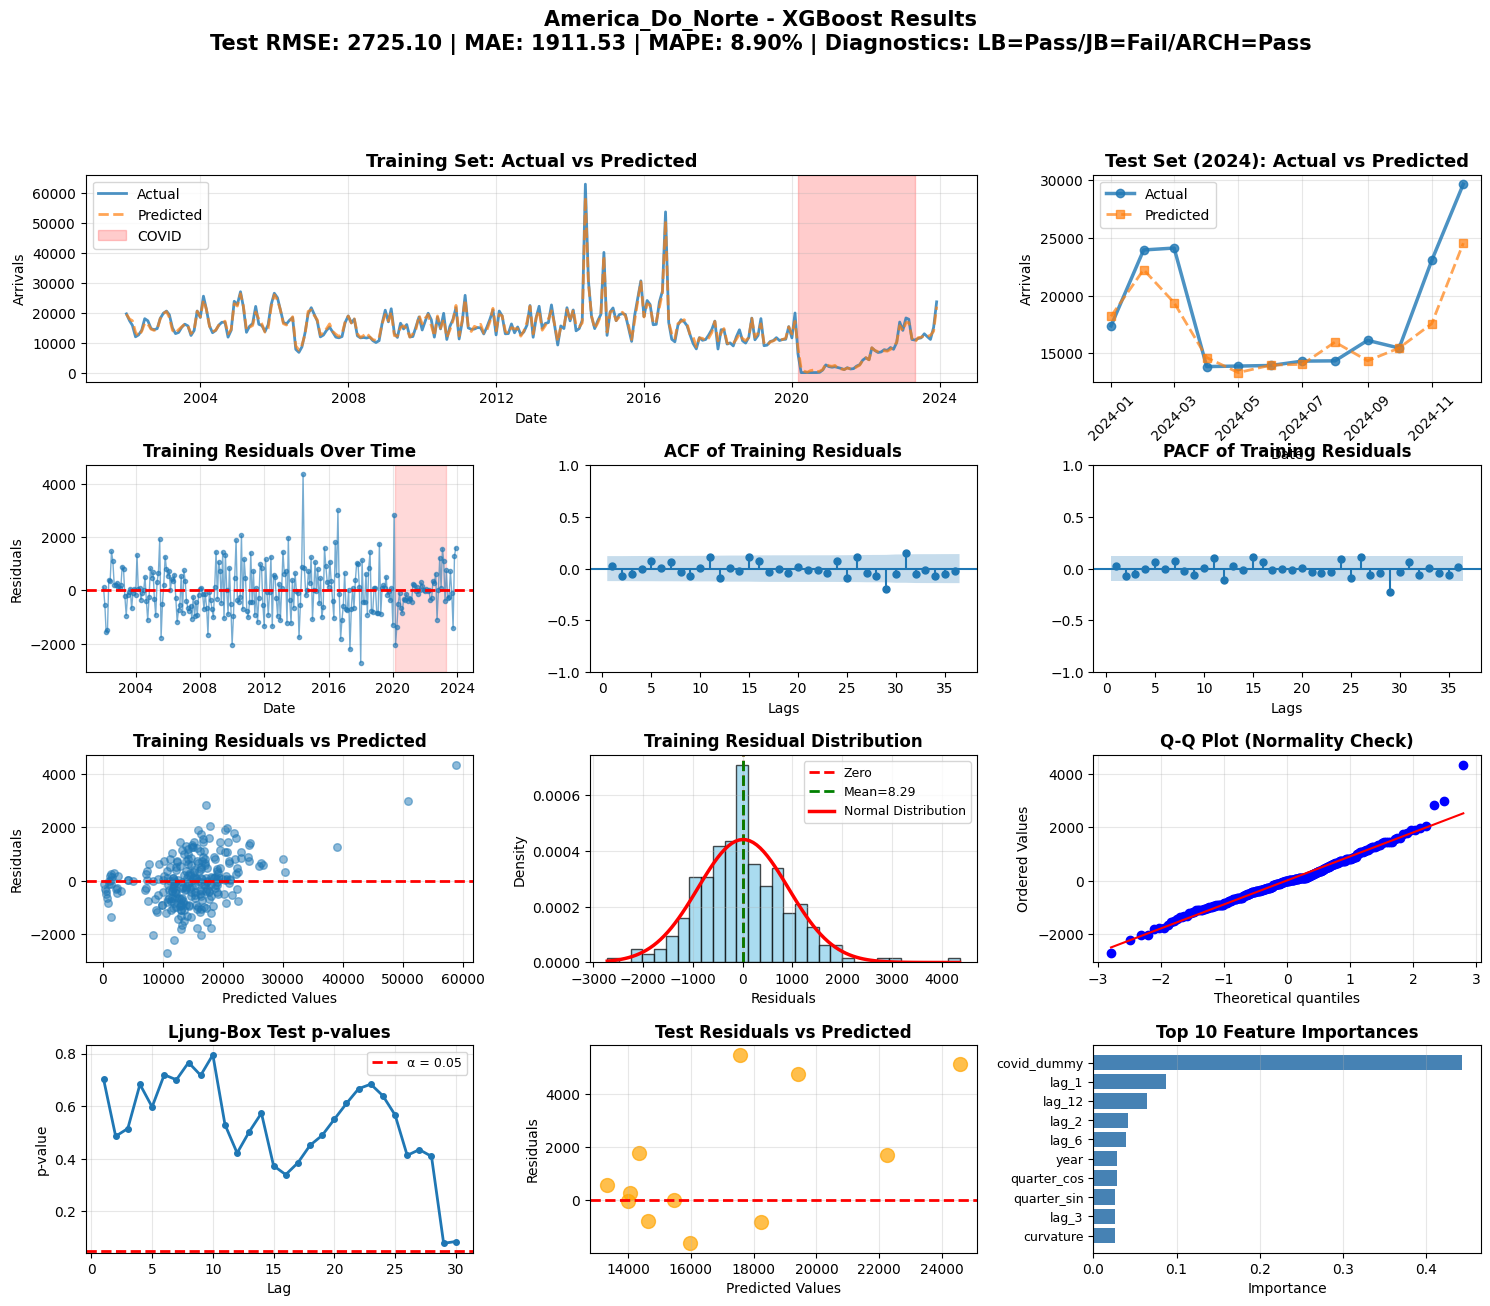


Gerando gráficos para: America_Do_Sul

--- Residual Diagnostics (Training Set) ---
Residual Mean: 45.8992
Residual Std: 2622.46

T-Test for Zero Mean:
  t-statistic: 0.2838
  p-value: 0.7768
  ✓ PASS: Mean não é significativamente diferente de zero (p > 0.05)
  ✓✓ EXCELENTE: |Mean| < 5% do Std (131.12)

Ljung-Box Test (lag 24):
  p-value: 0.5118
  ✓ PASS: No significant autocorrelation (p > 0.05)

Jarque-Bera Test (Normality):
  Statistic: 40.8357
  p-value: 0.0000
  ✗ FAIL: Residuals are not normally distributed (p < 0.05)

ARCH Test (Heteroskedasticity):
  p-value: 0.5708
  ✓ PASS: No heteroskedasticity (p > 0.05)

--- Overall Residual Diagnostics ---
⚠️ SOME TESTS FAILED - Review residual diagnostics


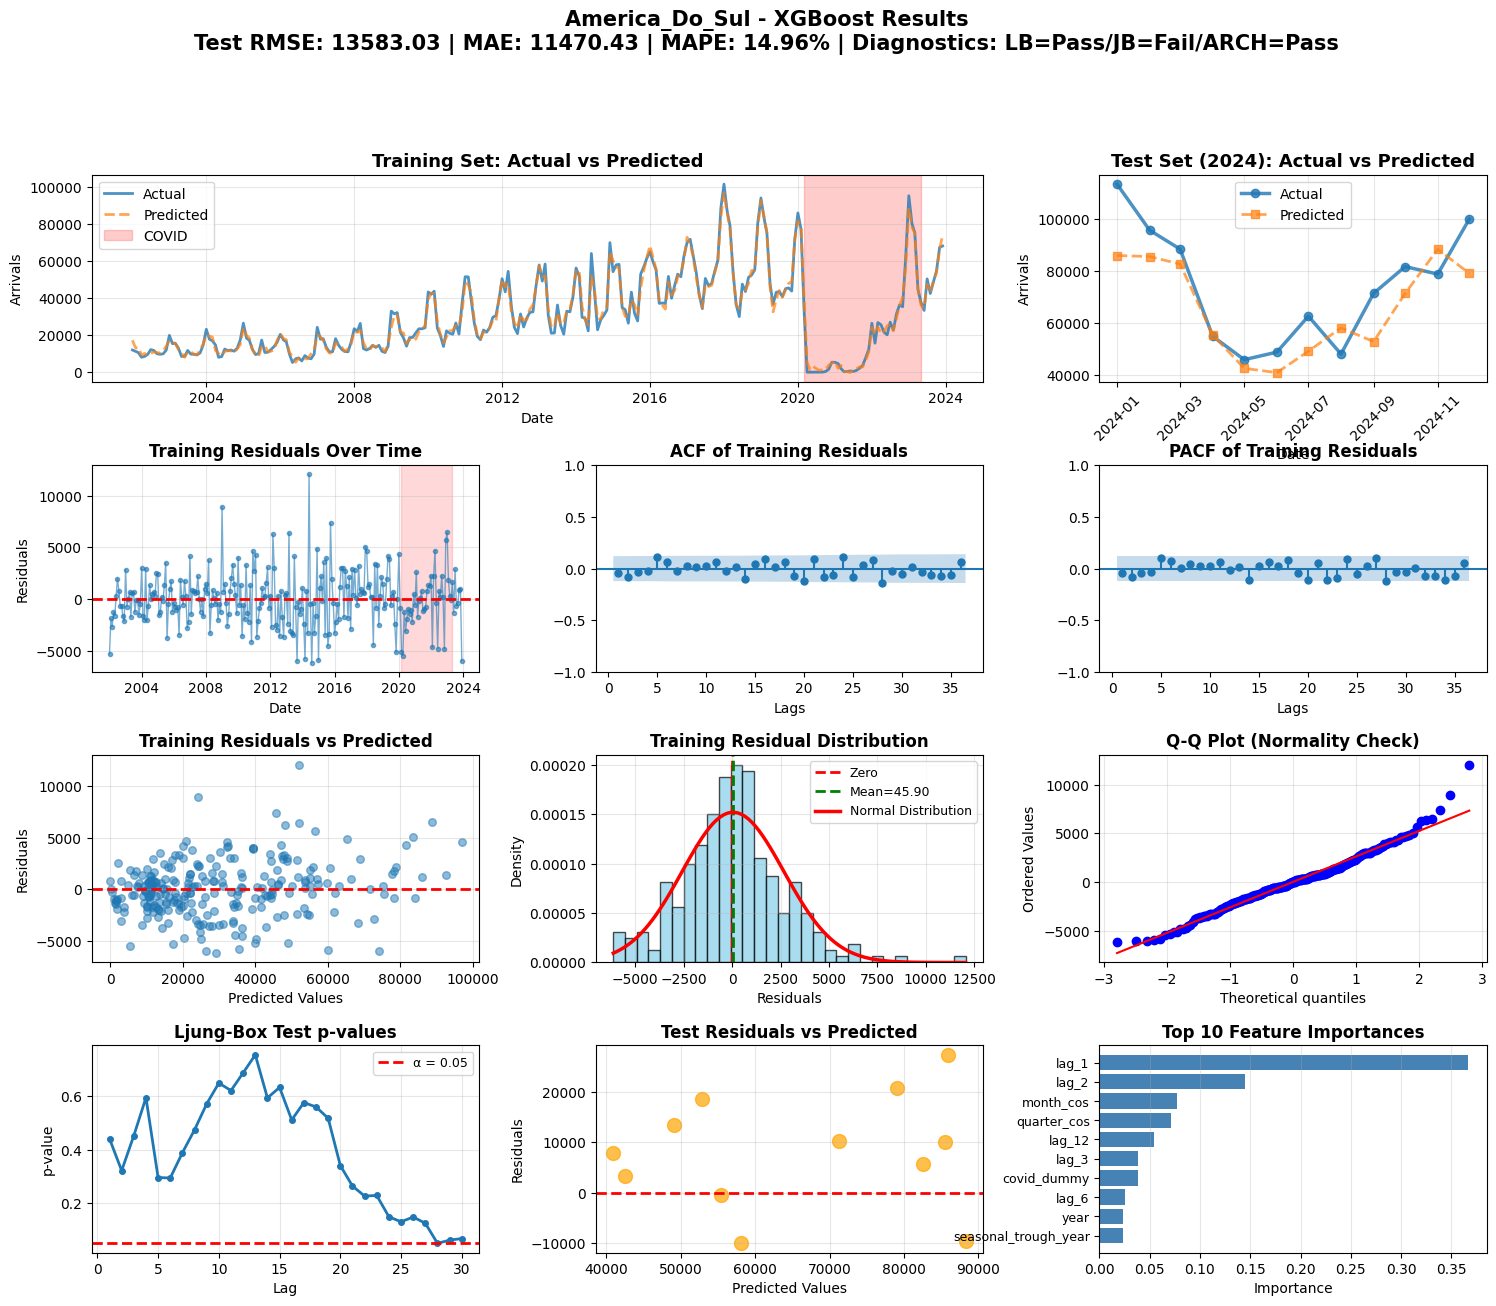


Gerando gráficos para: Asia

--- Residual Diagnostics (Training Set) ---
Residual Mean: 8.5188
Residual Std: 1379.65

T-Test for Zero Mean:
  t-statistic: 0.1001
  p-value: 0.9203
  ✓ PASS: Mean não é significativamente diferente de zero (p > 0.05)
  ✓✓ EXCELENTE: |Mean| < 5% do Std (68.98)

Ljung-Box Test (lag 24):
  p-value: 0.0000
  ✗ FAIL: Significant autocorrelation detected (p < 0.05)

Jarque-Bera Test (Normality):
  Statistic: 14545.6430
  p-value: 0.0000
  ✗ FAIL: Residuals are not normally distributed (p < 0.05)

ARCH Test (Heteroskedasticity):
  p-value: 0.1486
  ✓ PASS: No heteroskedasticity (p > 0.05)

--- Overall Residual Diagnostics ---
⚠️ SOME TESTS FAILED - Review residual diagnostics


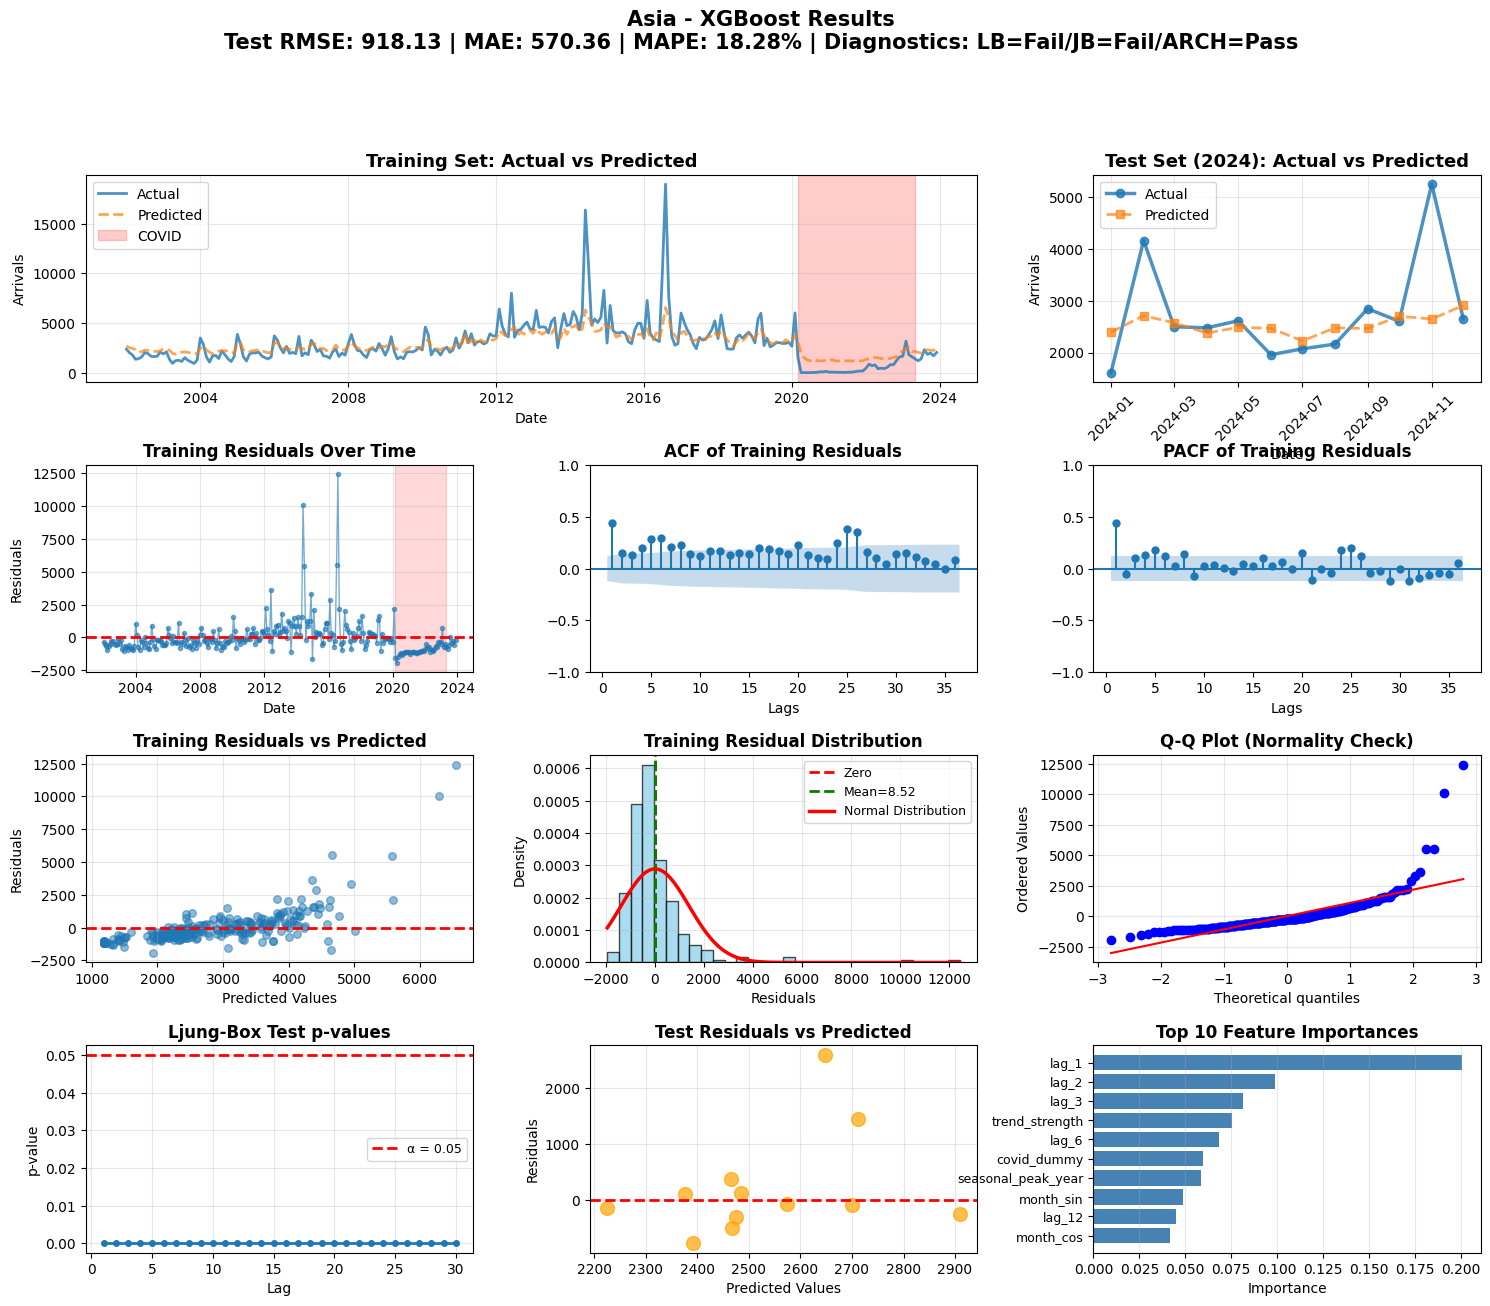


Gerando gráficos para: Europa

--- Residual Diagnostics (Training Set) ---
Residual Mean: 2.3954
Residual Std: 2106.45

T-Test for Zero Mean:
  t-statistic: 0.0184
  p-value: 0.9853
  ✓ PASS: Mean não é significativamente diferente de zero (p > 0.05)
  ✓✓ EXCELENTE: |Mean| < 5% do Std (105.32)

Ljung-Box Test (lag 24):
  p-value: 0.9510
  ✓ PASS: No significant autocorrelation (p > 0.05)

Jarque-Bera Test (Normality):
  Statistic: 1064.1988
  p-value: 0.0000
  ✗ FAIL: Residuals are not normally distributed (p < 0.05)

ARCH Test (Heteroskedasticity):
  p-value: 0.0026
  ✗ FAIL: Heteroskedasticity detected (p < 0.05)

--- Overall Residual Diagnostics ---
⚠️ SOME TESTS FAILED - Review residual diagnostics


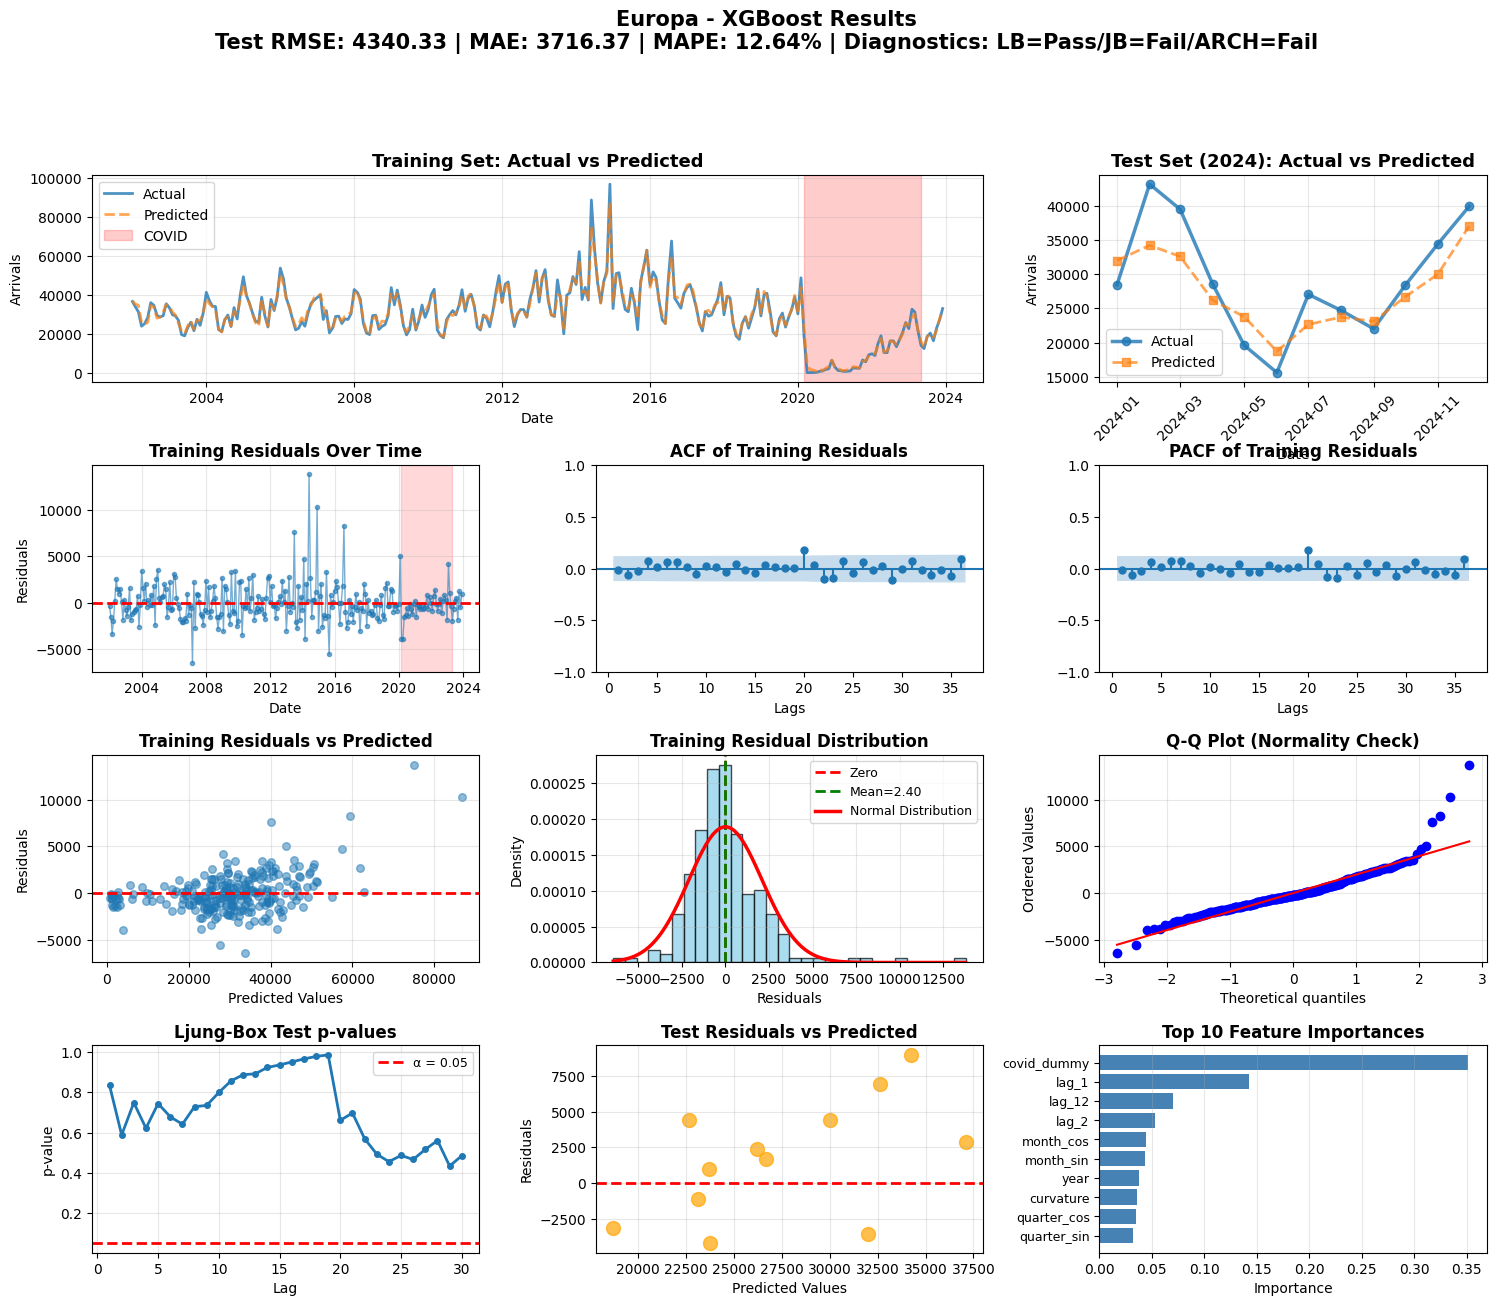


Gerando gráficos para: Oceania

--- Residual Diagnostics (Training Set) ---
Residual Mean: 0.7542
Residual Std: 57.48

T-Test for Zero Mean:
  t-statistic: 0.2128
  p-value: 0.8316
  ✓ PASS: Mean não é significativamente diferente de zero (p > 0.05)
  ✓✓ EXCELENTE: |Mean| < 5% do Std (2.87)

Ljung-Box Test (lag 24):
  p-value: 0.7097
  ✓ PASS: No significant autocorrelation (p > 0.05)

Jarque-Bera Test (Normality):
  Statistic: 107.9591
  p-value: 0.0000
  ✗ FAIL: Residuals are not normally distributed (p < 0.05)

ARCH Test (Heteroskedasticity):
  p-value: 0.8623
  ✓ PASS: No heteroskedasticity (p > 0.05)

--- Overall Residual Diagnostics ---
⚠️ SOME TESTS FAILED - Review residual diagnostics


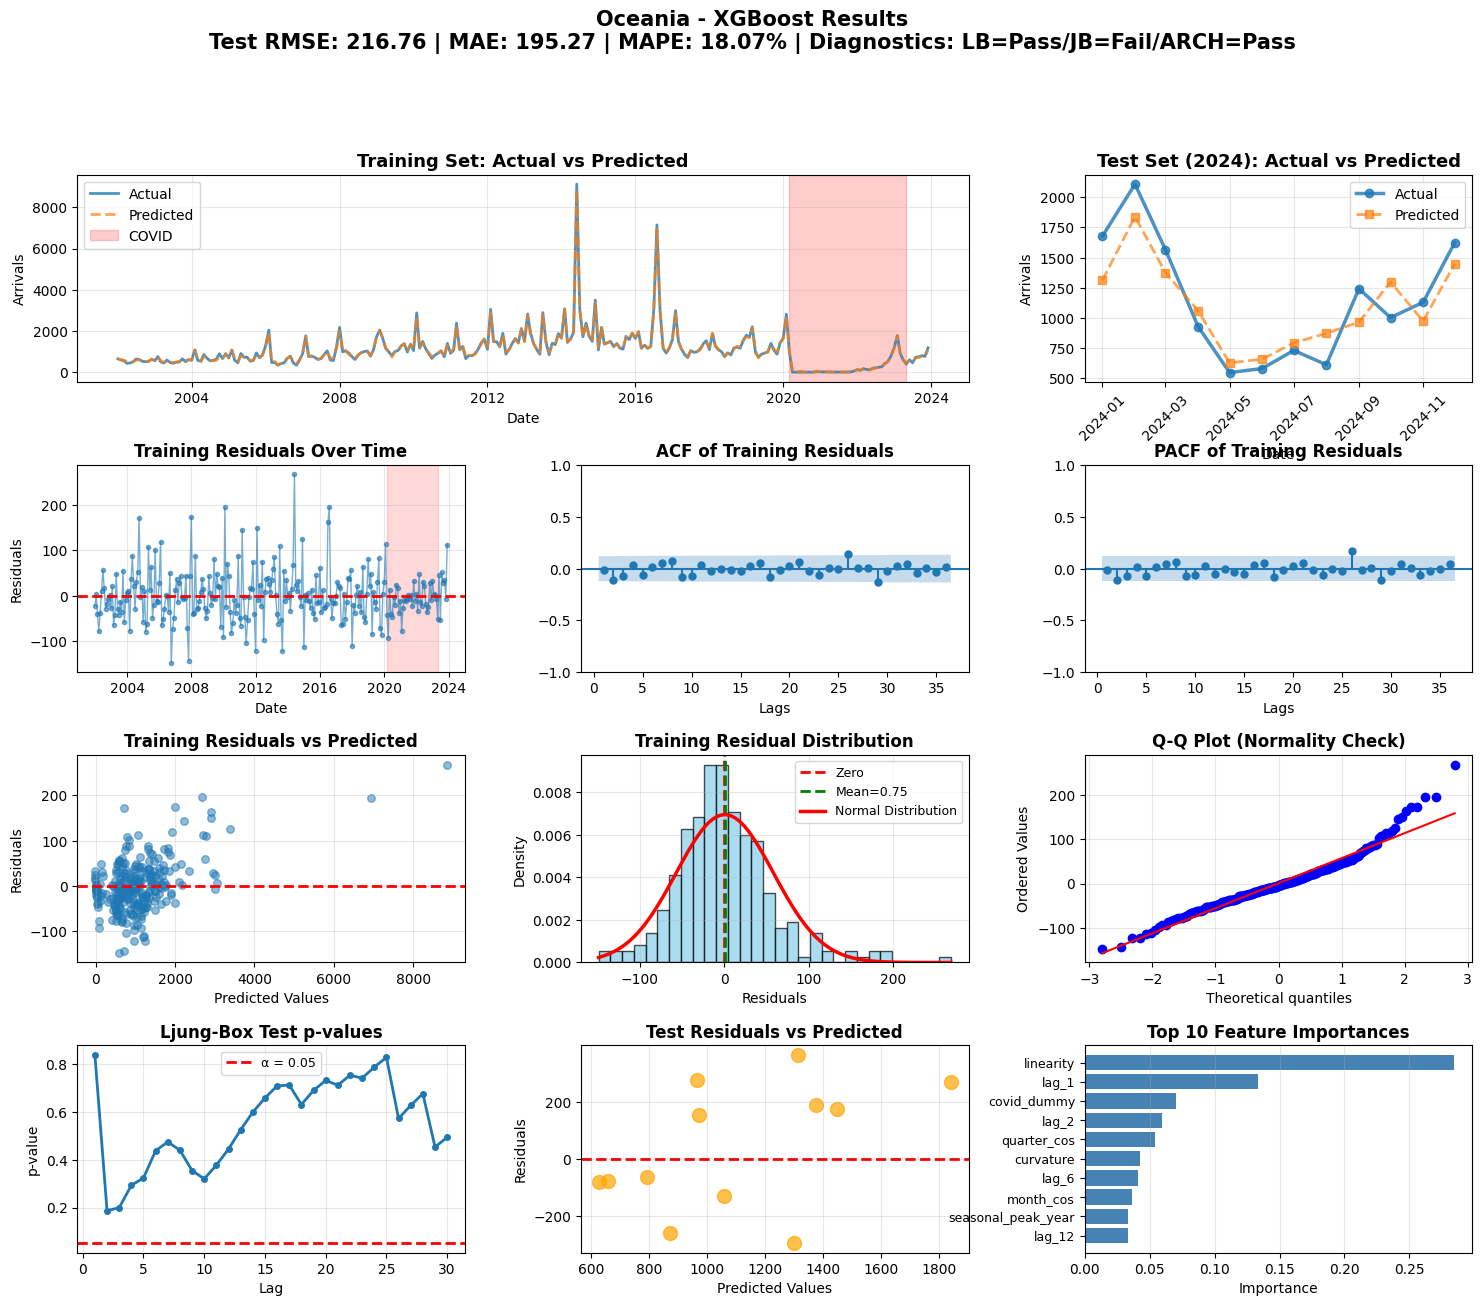


✓ Todas as visualizações criadas


In [10]:
print("="*80)
print("VISUALIZAÇÕES - XGBOOST RESULTADOS")
print("="*80 + "\n")

# Import necessário para ACF/PACF e testes estatísticos
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats

# Para cada continente, criar gráficos
for continent in continents:
    if continent not in xgb_models:
        continue
    
    print(f"\nGerando gráficos para: {continent.title()}")
    
    model_data = xgb_models[continent]
    train_data = model_data['train_data']
    test_data = model_data['test_data']
    y_pred_train = model_data['y_pred_train']
    y_pred_test = model_data['y_pred_test']
    feature_importance = model_data['feature_importance']
    
    # Calculate residuals
    residuals_train = train_data['arrivals'].values - y_pred_train
    residuals_test = test_data['arrivals'].values - y_pred_test
    
    # ========================================
    # RESIDUAL DIAGNOSTICS
    # ========================================
    print(f"\n--- Residual Diagnostics (Training Set) ---")
    print(f"Residual Mean: {residuals_train.mean():.4f}")
    print(f"Residual Std: {residuals_train.std():.2f}")

        # 0. T-Test for Zero Mean (NEW!)
    print(f"\nT-Test for Zero Mean:")
    from scipy.stats import ttest_1samp
    t_stat, t_pvalue = ttest_1samp(residuals_train, 0)
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value: {t_pvalue:.4f}")
    
    # Calcular threshold baseado em % do desvio padrão
    threshold_5pct = 0.05 * residuals_train.std()
    threshold_10pct = 0.10 * residuals_train.std()
    mean_abs = abs(residuals_train.mean())
    
    if t_pvalue > 0.05:
        print(f"  ✓ PASS: Mean não é significativamente diferente de zero (p > 0.05)")
        if mean_abs < threshold_5pct:
            print(f"  ✓✓ EXCELENTE: |Mean| < 5% do Std ({threshold_5pct:.2f})")
            mean_result = "Excellent"
        elif mean_abs < threshold_10pct:
            print(f"  ✓ BOM: |Mean| < 10% do Std ({threshold_10pct:.2f})")
            mean_result = "Good"
        else:
            print(f"  ⚠️ ACEITÁVEL: |Mean| > 10% do Std, mas estatisticamente = 0")
            mean_result = "Acceptable"
    else:
        print(f"  ✗ FAIL: Mean é significativamente diferente de zero (p < 0.05)")
        if residuals_train.mean() > 0:
            print(f"  → Modelo SUBESTIMA sistematicamente os valores reais")
        else:
            print(f"  → Modelo SUPERESTIMA sistematicamente os valores reais")
        mean_result = "Biased"
    
    # 1. Ljung-Box Test (autocorrelation) - 24 lags
    print(f"\nLjung-Box Test (lag 24):")
    lb_test = acorr_ljungbox(residuals_train, lags=16, return_df=True)
    lb_pvalue = lb_test['lb_pvalue'].iloc[-1]  # Last lag p-value
    print(f"  p-value: {lb_pvalue:.4f}")
    if lb_pvalue > 0.05:
        print(f"  ✓ PASS: No significant autocorrelation (p > 0.05)")
        lb_result = "Pass"
    else:
        print(f"  ✗ FAIL: Significant autocorrelation detected (p < 0.05)")
        lb_result = "Fail"
    
    # 2. Jarque-Bera Test (normality)
    jb_stat, jb_pvalue = stats.jarque_bera(residuals_train)
    print(f"\nJarque-Bera Test (Normality):")
    print(f"  Statistic: {jb_stat:.4f}")
    print(f"  p-value: {jb_pvalue:.4f}")
    if jb_pvalue > 0.05:
        print(f"  ✓ PASS: Residuals are normally distributed (p > 0.05)")
        jb_result = "Pass"
    else:
        print(f"  ✗ FAIL: Residuals are not normally distributed (p < 0.05)")
        jb_result = "Fail"
    
    # 3. Heteroskedasticity (ARCH test)
    from statsmodels.stats.diagnostic import het_arch
    try:
        arch_test = het_arch(residuals_train, nlags=10)
        arch_pvalue = arch_test[1]
        print(f"\nARCH Test (Heteroskedasticity):")
        print(f"  p-value: {arch_pvalue:.4f}")
        if arch_pvalue > 0.05:
            print(f"  ✓ PASS: No heteroskedasticity (p > 0.05)")
            arch_result = "Pass"
        else:
            print(f"  ✗ FAIL: Heteroskedasticity detected (p < 0.05)")
            arch_result = "Fail"
    except:
        arch_result = "Error"
        arch_pvalue = np.nan
        print(f"\nARCH Test: Could not be performed")
    
    # Overall diagnostic result
    print(f"\n--- Overall Residual Diagnostics ---")
    all_pass = all([lb_result == "Pass", jb_result == "Pass", arch_result == "Pass"])
    if all_pass:
        print("✓✓✓ ALL TESTS PASSED - Model residuals are well-behaved")
        diagnostic_result = "All Pass"
    else:
        print("⚠️ SOME TESTS FAILED - Review residual diagnostics")
        diagnostic_result = "Some Fail"
    
    # ========================================
    # VISUALIZATION
    # ========================================
    
    # Create figure with subplots (aumentado para 4x3)
    fig = plt.figure(figsize=(18, 14))
    gs = fig.add_gridspec(4, 3, hspace=0.4, wspace=0.3)
    
    # Plot 1: Train - Actual vs Predicted
    ax1 = fig.add_subplot(gs[0, :2])
    ax1.plot(train_data['date'], train_data['arrivals'], label='Actual', linewidth=2, alpha=0.8)
    ax1.plot(train_data['date'], y_pred_train, label='Predicted', linewidth=2, alpha=0.7, linestyle='--')
    ax1.axvspan(pd.Timestamp('2020-03-01'), pd.Timestamp('2023-05-01'), 
                alpha=0.2, color='red', label='COVID')
    ax1.set_title('Training Set: Actual vs Predicted', fontsize=13, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Arrivals')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Test - Actual vs Predicted
    ax2 = fig.add_subplot(gs[0, 2])
    ax2.plot(test_data['date'], test_data['arrivals'], label='Actual', 
             linewidth=2.5, marker='o', markersize=6, alpha=0.8)
    ax2.plot(test_data['date'], y_pred_test, label='Predicted', 
             linewidth=2, alpha=0.7, marker='s', markersize=6, linestyle='--')
    ax2.set_title('Test Set (2024): Actual vs Predicted', fontsize=13, fontweight='bold')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Arrivals')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    # Plot 3: Residuals Over Time (Train)
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(train_data['date'], residuals_train, marker='o', markersize=3, alpha=0.6, linewidth=1)
    ax3.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax3.axvspan(pd.Timestamp('2020-03-01'), pd.Timestamp('2023-05-01'), 
                alpha=0.15, color='red')
    ax3.set_title('Training Residuals Over Time', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Date', fontsize=10)
    ax3.set_ylabel('Residuals', fontsize=10)
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: ACF of Residuals (Training)
    ax4 = fig.add_subplot(gs[1, 1])
    plot_acf(residuals_train, lags=36, ax=ax4, zero=False)
    ax4.set_title('ACF of Training Residuals', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Lags', fontsize=10)
    
    # Plot 5: PACF of Residuals (Training)
    ax5 = fig.add_subplot(gs[1, 2])
    plot_pacf(residuals_train, lags=36, ax=ax5, zero=False, method='ywm')
    ax5.set_title('PACF of Training Residuals', fontsize=12, fontweight='bold')
    ax5.set_xlabel('Lags', fontsize=10)
    
    # Plot 6: Residuals vs Fitted (Train)
    ax6 = fig.add_subplot(gs[2, 0])
    ax6.scatter(y_pred_train, residuals_train, alpha=0.5, s=30)
    ax6.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax6.set_title('Training Residuals vs Predicted', fontsize=12, fontweight='bold')
    ax6.set_xlabel('Predicted Values', fontsize=10)
    ax6.set_ylabel('Residuals', fontsize=10)
    ax6.grid(True, alpha=0.3)
    
    # Plot 7: Histogram of Residuals with Normal Overlay
    ax7 = fig.add_subplot(gs[2, 1])
    ax7.hist(residuals_train, bins=30, alpha=0.7, edgecolor='black', density=True, color='skyblue')
    ax7.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero')
    ax7.axvline(x=residuals_train.mean(), color='green', linestyle='--', linewidth=2, label=f'Mean={residuals_train.mean():.2f}')
    
    # Add normal distribution overlay
    mu, sigma = residuals_train.mean(), residuals_train.std()
    x = np.linspace(residuals_train.min(), residuals_train.max(), 100)
    ax7.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2.5, label='Normal Distribution')
    
    ax7.set_title('Training Residual Distribution', fontsize=12, fontweight='bold')
    ax7.set_xlabel('Residuals', fontsize=10)
    ax7.set_ylabel('Density', fontsize=10)
    ax7.legend(fontsize=9)
    ax7.grid(True, alpha=0.3)
    
    # Plot 8: Q-Q Plot (Normal probability plot)
    ax8 = fig.add_subplot(gs[2, 2])
    stats.probplot(residuals_train, dist="norm", plot=ax8)
    ax8.set_title('Q-Q Plot (Normality Check)', fontsize=12, fontweight='bold')
    ax8.grid(True, alpha=0.3)
    
    # Plot 9: Ljung-Box p-values by Lag
    ax9 = fig.add_subplot(gs[3, 0])
    lb_test_full = acorr_ljungbox(residuals_train, lags=30, return_df=True)
    ax9.plot(lb_test_full.index, lb_test_full['lb_pvalue'], marker='o', linewidth=2, markersize=4)
    ax9.axhline(y=0.05, color='r', linestyle='--', linewidth=2, label='α = 0.05')
    ax9.set_title('Ljung-Box Test p-values', fontsize=12, fontweight='bold')
    ax9.set_xlabel('Lag', fontsize=10)
    ax9.set_ylabel('p-value', fontsize=10)
    ax9.legend(fontsize=9)
    ax9.grid(True, alpha=0.3)
    
    # Plot 10: Test Residuals vs Predicted
    ax10 = fig.add_subplot(gs[3, 1])
    ax10.scatter(y_pred_test, residuals_test, alpha=0.7, s=100, color='orange')
    ax10.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax10.set_title('Test Residuals vs Predicted', fontsize=12, fontweight='bold')
    ax10.set_xlabel('Predicted Values', fontsize=10)
    ax10.set_ylabel('Residuals', fontsize=10)
    ax10.grid(True, alpha=0.3)
    
    # Plot 11: Feature Importance
    ax11 = fig.add_subplot(gs[3, 2])
    top_features = feature_importance.head(10)
    ax11.barh(range(len(top_features)), top_features['importance'], color='steelblue')
    ax11.set_yticks(range(len(top_features)))
    ax11.set_yticklabels(top_features['feature'], fontsize=9)
    ax11.invert_yaxis()
    ax11.set_title('Top 10 Feature Importances', fontsize=12, fontweight='bold')
    ax11.set_xlabel('Importance', fontsize=10)
    ax11.grid(True, alpha=0.3, axis='x')
    
    # Overall title
    continent_display = "TOTAL (Agregado)" if continent == 'TOTAL' else continent.title()
    result = results_df[results_df['Continent'] == continent_display].iloc[0]
    plt.suptitle(f"{continent.title()} - XGBoost Results\n" + 
                 f"Test RMSE: {result['Test_RMSE']:.2f} | MAE: {result['Test_MAE']:.2f} | MAPE: {result['Test_MAPE']:.2f}% | " +
                 f"Diagnostics: LB={lb_result}/JB={jb_result}/ARCH={arch_result}",
                 fontsize=15, fontweight='bold', y=0.998)
    
    plt.show()

print("\n✓ Todas as visualizações criadas")